In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.utils as utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config_xenium_multiplex.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config_xenium_multiplex.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config_xenium_multiplex.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config_xenium_multiplex.yaml']

In [6]:
# # just specify up front so it doesnt take so long to load objects
# channels = sc.read_h5ad(
#     '/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s3_xenium.h5ad'
# ).var.index.to_list()
# len(channels)

In [7]:
xenium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': .0,
        'codebook_size': 30,
        'decoder_dims': (256, 256, 256,)
    },
    'learner_kwargs': {
        'scale': 1.,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cuda:0',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 5000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 1000,
#         'save_dir': chkpt_dir       
    },
}

In [8]:
# config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config_xenium_multiplex.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config_xenium_multiplex.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config_xenium_multiplex.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/{case}_xenium/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [9]:
config

[{'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s0_multiplex.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 15},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 35},
 {'data': [{'dtype': 'multiplex_codex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 40},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s4_multiplex.ome.tiff'}],
  'id': 's4',
  'position': 50},
 {'data': [{'dtype': 'multiplex_codex',
    'filepath': '/data/estorrs/mushroom/data/proje

In [10]:
# only keep the non-detached sections

In [11]:
for entry in config:
    if entry['data'][0]['dtype'] == 'multiplex':
        print(entry['id'], entry['position'])

s0 0
s1 15
s2 35
s4 50


In [12]:
xenium_config['sections'] = config
xenium_config['train_kwargs']['save_dir'] = chkpt_dir

In [13]:
mushroom = Mushroom.from_config(xenium_config)

INFO:root:using device: cuda:0
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 477 channels
INFO:root:4 sections detected: ['s0', 's1', 's2', 's4']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s2
INFO:root:generating image data for section s4
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [14]:
# a1 = sc.read_h5ad('/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad')
# a1

In [15]:
# a2 = sc.read_h5ad('/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s3_xenium.h5ad')
# a2

In [16]:
next(iter(mushroom.learner.inference_ds.section_to_img.values())).shape

torch.Size([477, 182, 161])

In [17]:
mushroom.true_imgs.shape

torch.Size([4, 477, 180, 164])

In [18]:
b = next(iter(mushroom.learner.train_dl))

In [19]:
for k, v in b.items(): print(k, v.shape)

anchor_idx torch.Size([64])
pos_idx torch.Size([64])
anchor_tile torch.Size([64, 477, 8, 8])
pos_tile torch.Size([64, 477, 8, 8])


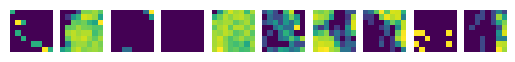

In [20]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['anchor_tile'][i, mushroom.learner.channels.index('EPCAM')])
    ax.axis('off')

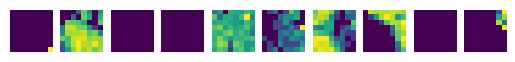

In [21]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['pos_tile'][i, mushroom.learner.channels.index('EPCAM')])
    ax.axis('off')

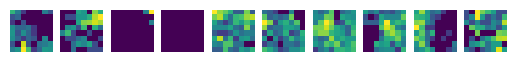

In [22]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['anchor_tile'][i, mushroom.learner.channels.index('PTPRC')])
    ax.axis('off')

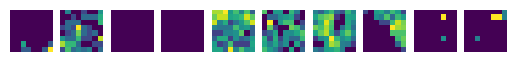

In [23]:
fig, axs = plt.subplots(ncols=10)
for i, ax in enumerate(axs):
    ax.imshow(b['pos_tile'][i, mushroom.learner.channels.index('PTPRC')])
    ax.axis('off')

In [24]:
with torch.no_grad():
    device = mushroom.learner.device
    anchor_x, anchor_slide = b['anchor_tile'], b['anchor_idx']
    pos_x, pos_slide = b['pos_tile'], b['pos_idx']
    x = torch.concat((anchor_x, pos_x))
    slide = torch.concat((anchor_slide, pos_slide))
    x, slide = x.to(device), slide.to(device)

    losses, outputs = mushroom.learner.sae(x, slide)

In [25]:
for k, v in losses.items(): print(k, v)

overall_loss tensor(0.9714, device='cuda:0')
recon_loss tensor(0.9714, device='cuda:0')
kl_loss tensor(65.6435, device='cuda:0')
neigh_loss tensor(3.3961, device='cuda:0')


In [26]:
for k, v in outputs.items(): print(k, v.shape)

encoded_tokens_prequant torch.Size([128, 65, 256])
encoded_tokens torch.Size([128, 65, 256])
pred_pixel_values torch.Size([128, 64, 477])
clusters torch.Size([128, 64])


In [27]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(0.9925, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9925, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(65.7312, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.3958, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943_xenium/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(1.1509, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1509, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(102.6153, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.1324, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(1.0439, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0439, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(142.1774, device='cuda:0', grad_fn=<MeanBa

INFO:root:iteration 260: {'overall_loss': tensor(0.8002, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.8002, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(348.2639, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9707, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 270: {'overall_loss': tensor(0.6284, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6284, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(376.7783, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8065, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 280: {'overall_loss': tensor(0.7682, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7682, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(379.7631, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9057, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 290: {'overall_loss'

INFO:root:iteration 520: {'overall_loss': tensor(0.6418, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6418, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(374.7055, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9779, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 530: {'overall_loss': tensor(0.6717, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6717, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(382.3872, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8764, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 540: {'overall_loss': tensor(0.6547, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6547, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(382.6426, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8337, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 550: {'overall_loss'

INFO:root:iteration 780: {'overall_loss': tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6057, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(483.2999, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9623, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 790: {'overall_loss': tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5436, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(481.9367, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9604, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 800: {'overall_loss': tensor(0.6306, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6306, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(495.4558, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8244, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 810: {'overall_loss'

INFO:root:iteration 1040: {'overall_loss': tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5849, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(515.6862, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8440, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1050: {'overall_loss': tensor(0.6398, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6398, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(517.7955, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9483, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1060: {'overall_loss': tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5140, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(510.7002, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8744, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1070: {'overall_l

INFO:root:iteration 1300: {'overall_loss': tensor(0.6790, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6790, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(563.3262, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.0074, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1310: {'overall_loss': tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4966, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(578.4053, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8053, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1320: {'overall_loss': tensor(0.6815, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6815, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(569.0769, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9520, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1330: {'overall_l

INFO:root:iteration 1560: {'overall_loss': tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4567, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(555.2424, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.7507, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1570: {'overall_loss': tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5632, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(558.2698, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8613, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1580: {'overall_loss': tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6085, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(566.1093, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8814, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1590: {'overall_l

INFO:root:iteration 1820: {'overall_loss': tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5126, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(612.2576, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9536, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1830: {'overall_loss': tensor(0.5873, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5873, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(602.7371, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8404, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1840: {'overall_loss': tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5664, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(651.4545, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8806, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 1850: {'overall_l

INFO:root:iteration 2080: {'overall_loss': tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5714, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(568.5088, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.7800, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2090: {'overall_loss': tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5866, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(575.2577, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9338, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2100: {'overall_loss': tensor(0.7139, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7139, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(606.9772, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9670, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2110: {'overall_l

INFO:root:iteration 2340: {'overall_loss': tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5082, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(606.2407, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.7497, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2350: {'overall_loss': tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5358, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(626.9840, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8489, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2360: {'overall_loss': tensor(0.6086, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6086, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(603.0450, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8549, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2370: {'overall_l

INFO:root:iteration 2600: {'overall_loss': tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5238, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(594.6649, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8122, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2610: {'overall_loss': tensor(0.6630, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6630, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(630.9125, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(3.0200, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2620: {'overall_loss': tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5307, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(609.7186, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9222, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2630: {'overall_l

INFO:root:iteration 2860: {'overall_loss': tensor(0.6850, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6850, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(658.8090, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9178, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2870: {'overall_loss': tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5192, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(640.0055, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8249, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2880: {'overall_loss': tensor(0.5988, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5988, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(643.3400, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8802, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 2890: {'overall_l

INFO:root:iteration 3120: {'overall_loss': tensor(0.6935, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6935, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(692.5125, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8172, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3130: {'overall_loss': tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6004, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(683.1462, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9842, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3140: {'overall_loss': tensor(0.6421, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6421, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(691.2035, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9510, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3150: {'overall_l

INFO:root:iteration 3380: {'overall_loss': tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5566, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(655.5533, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8694, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3390: {'overall_loss': tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5760, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(660.9116, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8969, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3400: {'overall_loss': tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5469, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(653.8827, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8249, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3410: {'overall_l

INFO:root:iteration 3640: {'overall_loss': tensor(0.6059, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6059, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(693.0875, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9861, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3650: {'overall_loss': tensor(0.6203, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6203, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(695.2098, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9264, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3660: {'overall_loss': tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5618, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(689.0333, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9562, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3670: {'overall_l

INFO:root:iteration 3900: {'overall_loss': tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5246, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(677.8339, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8760, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3910: {'overall_loss': tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5890, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(701.4432, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9396, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3920: {'overall_loss': tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4925, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(669.6973, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8958, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 3930: {'overall_l

INFO:root:iteration 4160: {'overall_loss': tensor(0.6020, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6020, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(693.4247, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9418, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4170: {'overall_loss': tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5478, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(695.0506, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8413, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4180: {'overall_loss': tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5417, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(686.7966, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9333, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4190: {'overall_l

INFO:root:iteration 4420: {'overall_loss': tensor(0.6982, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6982, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(726.6885, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9370, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4430: {'overall_loss': tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5193, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(670.7094, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8229, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4440: {'overall_loss': tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5039, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(675.9045, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9141, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4450: {'overall_l

INFO:root:iteration 4680: {'overall_loss': tensor(0.5556, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5556, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(725.0492, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.7786, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4690: {'overall_loss': tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6163, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(731.1859, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.9288, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4700: {'overall_loss': tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5752, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(729.9708, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8416, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4710: {'overall_l

INFO:root:iteration 4940: {'overall_loss': tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5689, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(729.7899, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8685, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4950: {'overall_loss': tensor(0.5481, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5481, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(739.2401, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8898, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4960: {'overall_loss': tensor(0.6584, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6584, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(771.6292, device='cuda:0', grad_fn=<MeanBackward0>), 'neigh_loss': tensor(2.8053, device='cuda:0', grad_fn=<NllLossBackward0>)}
INFO:root:iteration 4970: {'overall_l